In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from math import sqrt

df = pd.read_csv('dataset.csv').drop(columns=['Date'])

In [68]:
target = 'Revenue_(USD)'
X = df.drop(columns=[target])[740:].reset_index(drop=True)
y = df[target][740:].reset_index(drop=True)

display(X)
display(y)

,Average_views_per_viewer,Unique_viewers,Click_rate_(%),Impressions,Comments,Shares,Dislikes,Likes,Average_viewed_(%),Videos_published,Views,Watch_hours,Average_view_sec,Subs_accumulated
0,1.6966,3342.0,5.45,80154.0,23.0,28.0,9.0,285.0,24.13,0.0,5670.0,281.0401,178.0,53213.0
1,1.7040,3703.0,5.40,89412.0,26.0,23.0,4.0,315.0,23.65,0.0,6310.0,310.0110,176.0,53387.0
2,1.7296,3565.0,5.69,82419.0,40.0,32.0,3.0,344.0,23.68,0.0,6166.0,305.4844,178.0,53582.0
3,1.6349,9602.0,6.96,162769.0,183.0,40.0,11.0,1602.0,30.79,1.0,15698.0,910.9613,208.0,53850.0
4,1.6092,9930.0,6.89,182250.0,78.0,55.0,13.0,997.0,28.86,0.0,15979.0,854.6027,192.0,54127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,2.2721,105872.0,4.04,4376635.0,546.0,399.0,195.0,10594.0,25.75,0.0,240554.0,19512.3516,292.0,565123.0
388,1.8941,215712.0,5.83,4854638.0,2741.0,764.0,312.0,34422.0,30.35,4.0,408582.0,19855.7704,174.0,566855.0
389,2.1319,305881.0,6.08,7768271.0,4741.0,1055.0,521.0,56677.0,47.81,0.0,652105.0,54463.2654,300.0,570139.0
390,2.3468,152920.0,4.51,5788014.0,671.0,633.0,276.0,18458.0,41.24,0.0,358868.0,26757.4077,268.0,572582.0


0        1.438
1        1.545
2        1.532
3        4.096
4        4.233
        ...   
387    126.600
388    163.558
389    397.066
390    178.664
391    135.841
Name: Revenue_(USD), Length: 392, dtype: float64

# 1. Huấn luyện và đánh giá mô hình linear

In [69]:
def _is_df(X_like):
    return isinstance(X_like, pd.DataFrame)

def _metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

def my_linear(X_unused, y, datasets, splits, israndom):
    results = []
    for data_name, X_data in datasets.items():
        for split_name, test_size in splits.items():

            # Chia dữ liệu: random vs sequential
            if israndom:
                X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=42)
            else:
                n_train = int((1 - test_size) * len(y))
                if _is_df(X_data):
                    X_train, X_test = X_data.iloc[:n_train], X_data.iloc[n_train:]
                else:
                    X_train, X_test = X_data[:n_train], X_data[n_train:]
                y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]

            # Hồi quy tuyến tính: y = a + b^T x
            lr = LinearRegression()
            lr.fit(X_train, y_train)

            # Dự đoán & tính chỉ số
            y_tr_pred = lr.predict(X_train)
            y_te_pred = lr.predict(X_test)

            tr_r2, tr_rmse, tr_mae = _metrics(y_train, y_tr_pred)
            te_r2, te_rmse, te_mae = _metrics(y_test, y_te_pred)

            results.append({
                "Loại dữ liệu": data_name,
                "Tỷ lệ (Train:Val)": split_name,
                "Train R2": tr_r2,
                "Test R2": te_r2,
                "Train RMSE (USD)": tr_rmse,
                "Test RMSE (USD)": te_rmse,
                "Train MAE (USD)": tr_mae,
                "Test MAE (USD)": te_mae
            })
    return results


# 2.Hiển thị kết quả và mô hình hóa kết quả

In [70]:
def show_linear_results(results, title="Hồi quy tuyến tính"):
    df_res = pd.DataFrame(results).copy()
    for c in ["Train R2","Test R2"]:
        df_res[c] = df_res[c].round(3)
    for c in ["Train RMSE (USD)","Test RMSE (USD)","Train MAE (USD)","Test MAE (USD)"]:
        df_res[c] = df_res[c].round(3)

    print("\n", title)
    print(df_res.to_string(index=False))

    # Biểu đồ R² 
    plt.figure(figsize=(10,6))
    for name in df_res["Loại dữ liệu"].unique():
        sub = df_res[df_res["Loại dữ liệu"] == name]
        plt.plot(sub["Tỷ lệ (Train:Val)"], sub["Test R2"], marker="o", linestyle="-", label=f"{name} - Test R²")
        plt.plot(sub["Tỷ lệ (Train:Val)"], sub["Train R2"], marker="s", linestyle="--", label=f"{name} - Train R²")
    plt.title(f"So sánh R² - {title}")
    plt.xlabel("Tỷ lệ (Train:Val)")
    plt.ylabel("R²")
    plt.legend()
    plt.grid(True)
    plt.show()

## 2.1. Với bộ dữ liệu gốc

In [71]:
# Chuẩn hóa 
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print("\nSố chiều dữ liệu gốc (chuẩn hóa):", X_scaled.shape[1])

# PCA giữ 95% phương sai
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Số chiều sau PCA (95% var):", X_pca.shape[1])

datasets_raw = {
    "Dữ liệu gốc (Đã chuẩn hóa)": X_scaled,
    "Dữ liệu giảm chiều (PCA)": X_pca
}

splits = {
    "4:1 (test=20%)": 0.2,
    "7:3 (test=30%)": 0.3,
    "6:4 (test=40%)": 0.4
}



Số chiều dữ liệu gốc (chuẩn hóa): 14
Số chiều sau PCA (95% var): 6



 Hồi quy tuyến tính • RAW • random split
              Loại dữ liệu Tỷ lệ (Train:Val)  Train R2  Test R2  Train RMSE (USD)  Test RMSE (USD)  Train MAE (USD)  Test MAE (USD)
Dữ liệu gốc (Đã chuẩn hóa)    4:1 (test=20%)     0.976    0.960            10.855           10.162            6.642           6.041
Dữ liệu gốc (Đã chuẩn hóa)    7:3 (test=30%)     0.977    0.958            11.116           10.006            6.786           6.211
Dữ liệu gốc (Đã chuẩn hóa)    6:4 (test=40%)     0.978    0.962            11.102           10.569            6.726           6.593
  Dữ liệu giảm chiều (PCA)    4:1 (test=20%)     0.968    0.956            12.487           10.637            7.775           7.246
  Dữ liệu giảm chiều (PCA)    7:3 (test=30%)     0.969    0.955            12.889           10.313            7.975           6.971
  Dữ liệu giảm chiều (PCA)    6:4 (test=40%)     0.968    0.961            13.228           10.643            8.117           7.347


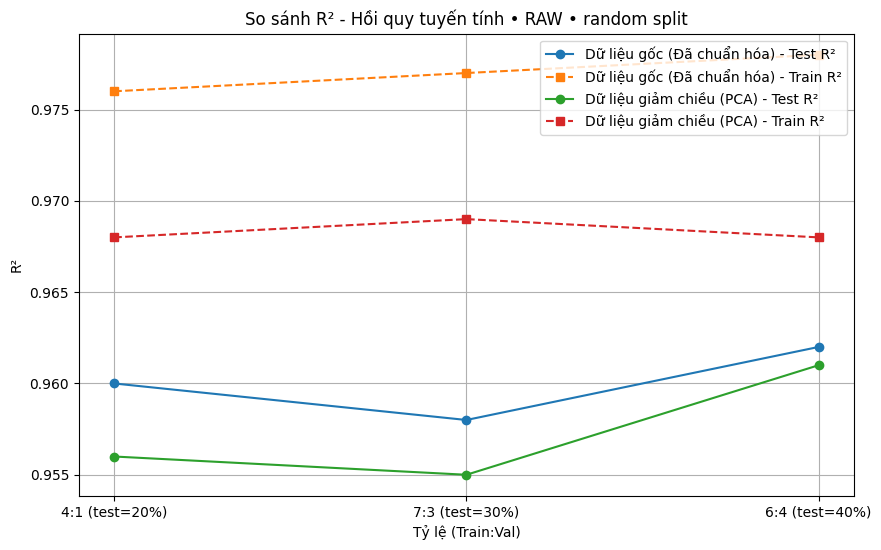

In [72]:
# chia tệp dữ liệu ngẫu nhiên
res_raw_rand = my_linear(X, y, datasets_raw, splits, israndom=True)
show_linear_results(res_raw_rand, "Hồi quy tuyến tính • RAW • random split")


 Hồi quy tuyến tính • RAW • sequential split
              Loại dữ liệu Tỷ lệ (Train:Val)  Train R2  Test R2  Train RMSE (USD)  Test RMSE (USD)  Train MAE (USD)  Test MAE (USD)
Dữ liệu gốc (Đã chuẩn hóa)    4:1 (test=20%)     0.975    0.750             5.760           37.814            3.947          32.757
Dữ liệu gốc (Đã chuẩn hóa)    7:3 (test=30%)     0.978    0.447             3.295           54.107            2.264          46.997
Dữ liệu gốc (Đã chuẩn hóa)    6:4 (test=40%)     0.974    0.854             2.339           27.621            1.622          22.503
  Dữ liệu giảm chiều (PCA)    4:1 (test=20%)     0.951    0.890             8.089           25.008            5.123          17.724
  Dữ liệu giảm chiều (PCA)    7:3 (test=30%)     0.966    0.684             4.093           40.925            2.775          31.069
  Dữ liệu giảm chiều (PCA)    6:4 (test=40%)     0.943    0.904             3.472           22.376            2.393          15.126


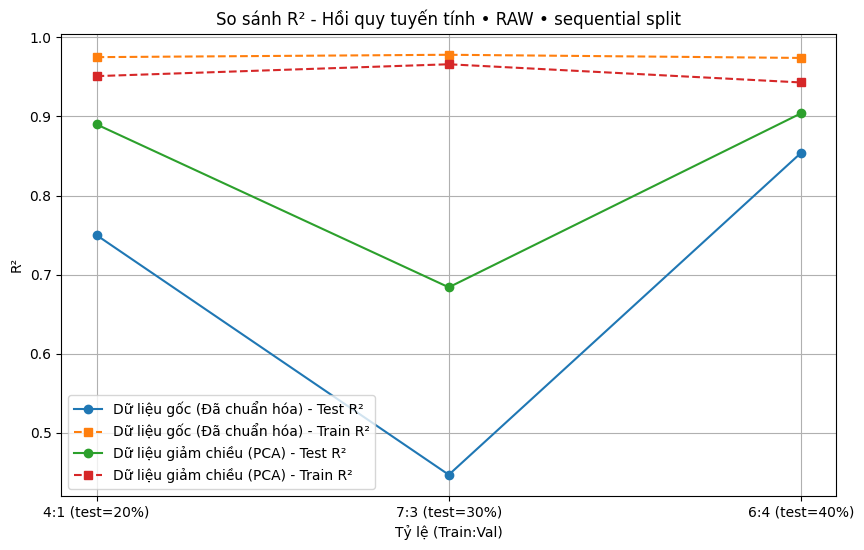

In [73]:
# chia tệp dữ liệu tuần tự
res_raw_seq = my_linear(X, y, datasets_raw, splits, israndom=False)
show_linear_results(res_raw_seq, "Hồi quy tuyến tính • RAW • sequential split")

## 2.2 Với dữ liệu biến đổi logarit

In [74]:
X_log = np.log1p(X)
y_log = np.log1p(y)

scaler_log = StandardScaler()
X_log_scaled = pd.DataFrame(scaler_log.fit_transform(X_log), columns=X.columns)
print("\nSố chiều dữ liệu log (chuẩn hóa):", X_log_scaled.shape[1])

pca_log = PCA(n_components=0.95, random_state=42)
X_log_pca = pca_log.fit_transform(X_log_scaled)
print("Số chiều sau PCA-log (95% var):", X_log_pca.shape[1])

datasets_log = {
    "Dữ liệu gốc (Đã chuẩn hóa)": X_log_scaled,
    "Dữ liệu giảm chiều (PCA)": X_log_pca
}


Số chiều dữ liệu log (chuẩn hóa): 14
Số chiều sau PCA-log (95% var): 5



 Hồi quy tuyến tính • LOG1P • random split
              Loại dữ liệu Tỷ lệ (Train:Val)  Train R2  Test R2  Train RMSE (USD)  Test RMSE (USD)  Train MAE (USD)  Test MAE (USD)
Dữ liệu gốc (Đã chuẩn hóa)    4:1 (test=20%)     0.986    0.983             0.151            0.164            0.118           0.130
Dữ liệu gốc (Đã chuẩn hóa)    7:3 (test=30%)     0.987    0.984             0.152            0.159            0.119           0.126
Dữ liệu gốc (Đã chuẩn hóa)    6:4 (test=40%)     0.988    0.982             0.147            0.166            0.115           0.130
  Dữ liệu giảm chiều (PCA)    4:1 (test=20%)     0.979    0.975             0.188            0.200            0.153           0.159
  Dữ liệu giảm chiều (PCA)    7:3 (test=30%)     0.979    0.976             0.191            0.190            0.154           0.152
  Dữ liệu giảm chiều (PCA)    6:4 (test=40%)     0.980    0.975             0.188            0.196            0.152           0.156


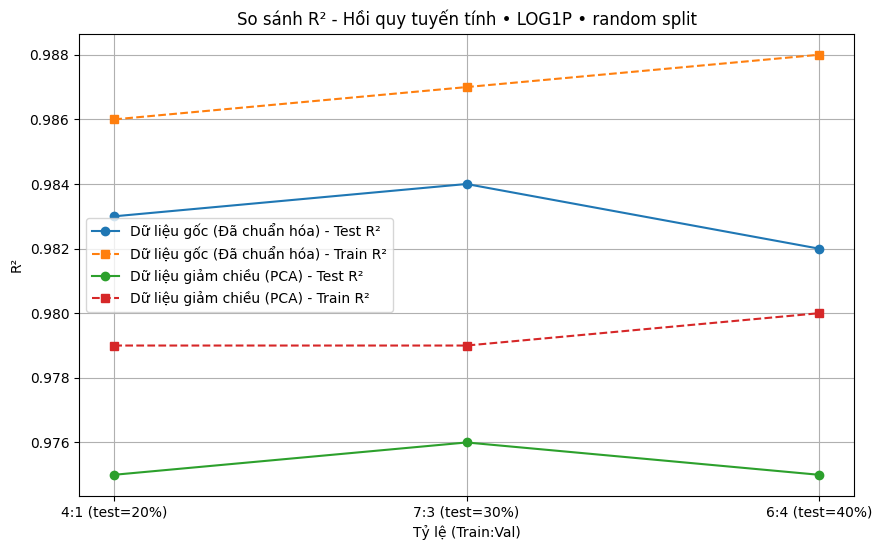

In [75]:
# chia tệp dữ liệu ngẫu nhiên
res_log_rand = my_linear(X_log, y_log, datasets_log, splits, israndom=True)
show_linear_results(res_log_rand, "Hồi quy tuyến tính • LOG1P • random split")


 Hồi quy tuyến tính • LOG1P • sequential split
              Loại dữ liệu Tỷ lệ (Train:Val)  Train R2  Test R2  Train RMSE (USD)  Test RMSE (USD)  Train MAE (USD)  Test MAE (USD)
Dữ liệu gốc (Đã chuẩn hóa)    4:1 (test=20%)     0.979    0.900             0.159            0.143            0.126           0.109
Dữ liệu gốc (Đã chuẩn hóa)    7:3 (test=30%)     0.977   -0.305             0.145            0.559            0.111           0.523
Dữ liệu gốc (Đã chuẩn hóa)    6:4 (test=40%)     0.967    0.560             0.151            0.391            0.114           0.340
  Dữ liệu giảm chiều (PCA)    4:1 (test=20%)     0.969    0.631             0.192            0.274            0.155           0.235
  Dữ liệu giảm chiều (PCA)    7:3 (test=30%)     0.960    0.490             0.190            0.350            0.147           0.308
  Dữ liệu giảm chiều (PCA)    6:4 (test=40%)     0.950    0.805             0.185            0.260            0.142           0.219


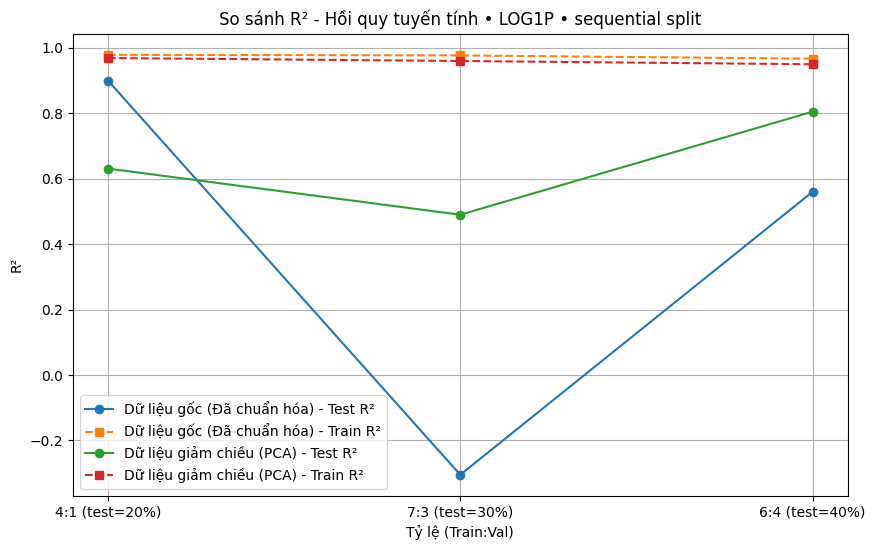

In [76]:
# chia tệp dữ liệu tuần tự
res_log_seq = my_linear(X_log, y_log, datasets_log, splits, israndom=False)
show_linear_results(res_log_seq, "Hồi quy tuyến tính • LOG1P • sequential split")

# 3.Phân tích hệ số hồi quy (a, b) trên toàn bộ dữ liệu RAW (đã chuẩn hóa)

In [77]:
lr_full = LinearRegression().fit(X_scaled, y)
a = float(lr_full.intercept_)
b = pd.Series(lr_full.coef_, index=X_scaled.columns).sort_values(key=np.abs, ascending=False)

print("\n============================")
print("Phân tích hồi quy (a, b)")
print("============================")
print(f"a : {a:.6f}")
print(f'các hệ số b_t theo đặc trưng t:')
print(b.to_string())



Phân tích hồi quy (a, b)
a : 53.494191
các hệ số b_t theo đặc trưng t:
Watch_hours                 48.705121
Likes                       18.772123
Impressions                -13.077984
Unique_viewers              10.354648
Subs_accumulated             9.152206
Comments                    -5.968025
Average_viewed_(%)           5.420703
Shares                      -3.713469
Average_view_sec            -2.993849
Dislikes                     1.260262
Average_views_per_viewer    -1.178207
Click_rate_(%)               0.613258
Views                        0.436241
Videos_published             0.125510
